In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj
from scipy.ndimage import gaussian_filter

/tmp/ipykernel_221587/2131041475.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition
flag_smooth = 1

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['264--12-10',
 '536--49-16',
 '63--47-04',
 '493--38-15',
 '338--46-11',
 '249--40-09',
 '210--45-08',
 '41--10-04',
 '540--07-17',
 '184--18-08',
 '411--30-13',
 '201--36-08',
 '406--25-13',
 '324--32-11',
 '15--23-03',
 '572--09-18',
 '307--08-11',
 '476--08-15',
 '55--31-04',
 '113--25-06',
 '175--51-07',
 '169--45-07',
 '385--49-12',
 '9--16-03',
 '218--53-08',
 '512--09-16',
 '183--17-08',
 '272--21-10',
 '545--13-17',
 '535--48-16',
 '56--32-04',
 '337--45-11',
 '89--40-05',
 '489--34-15',
 '575--12-18',
 '277--26-10',
 '556--35-17',
 '65--49-04',
 '10--18-03',
 '593--50-18',
 '199--34-08',
 '367--31-12',
 '390--54-12',
 '282--31-10',
 '204--39-08',
 '461--41-14',
 '423--42-13',
 '157--32-07',
 '392--09-13',
 '332--40-11',
 '442--18-14',
 '357--20-12',
 '353--15-12',
 '372--36-12',
 '233--24-09',
 '248--39-09',
 '531--44-16',
 '284--33-10',
 '191--25-08',
 '510--07-16',
 '568--53-17',
 '217--52-08',
 '36--52-03',
 '44--17-04',
 '521--34-16',
 '105--14-06',
 '437--08-14',
 '93--4

In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [9]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [10]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

lat_fault_wade = {}
lon_fault_wade = {}
for i in range(1,5):
    name_ref, lat_fault_wade[i], lon_fault_wade[i] = np.loadtxt('clark_fault_wade'+str(i)+'.txt',dtype='str' , unpack=True,delimiter=',')
    lon_fault_wade[i] = lon_fault_wade[i].astype(float)
    lat_fault_wade[i] = lat_fault_wade[i].astype(float)

### Interpolate 3D structure

In [11]:
dz = 5
N = 45
num_x = 100
num_y = 100
type_interp = 'linear'
flag_save = 1 # 1--npz; 2--mat

In [12]:
# Read all data
struc = {}
struc_fund = {}
flag = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    file_model_fund = dir_model_fund + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    model_fund = np.loadtxt(file_model_fund)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    struc_fund[key_subwork] = {}
    struc_fund[key_subwork]['layer'] = model_fund[:, 0]
    struc_fund[key_subwork]['z'] = model_fund[:, 1]
    struc_fund[key_subwork]['rho'] = model_fund[:, 2]
    struc_fund[key_subwork]['vs'] = model_fund[:, 3]
    struc_fund[key_subwork]['vp'] = model_fund[:, 4]
    struc_fund[key_subwork]['std'] = model_fund[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))

vs_horizon = {}
vs_horizon_fund = {}
for i in range(N):
    vs_horizon[i] = []
    vs_horizon_fund[i] = []
    for key_subwork in key_subworks:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])
        vs_horizon_fund[i].append(struc_fund[key_subwork]['vs'][i])

Read structure model: 264--12-10 (1/326)
Read structure model: 536--49-16 (2/326)
Read structure model: 63--47-04 (3/326)
Read structure model: 493--38-15 (4/326)
Read structure model: 338--46-11 (5/326)
Read structure model: 249--40-09 (6/326)
Read structure model: 210--45-08 (7/326)
Read structure model: 41--10-04 (8/326)
Read structure model: 540--07-17 (9/326)
Read structure model: 184--18-08 (10/326)
Read structure model: 411--30-13 (11/326)
Read structure model: 201--36-08 (12/326)
Read structure model: 406--25-13 (13/326)
Read structure model: 324--32-11 (14/326)
Read structure model: 15--23-03 (15/326)
Read structure model: 572--09-18 (16/326)
Read structure model: 307--08-11 (17/326)
Read structure model: 476--08-15 (18/326)
Read structure model: 55--31-04 (19/326)
Read structure model: 113--25-06 (20/326)
Read structure model: 175--51-07 (21/326)
Read structure model: 169--45-07 (22/326)
Read structure model: 385--49-12 (23/326)
Read structure model: 9--16-03 (24/326)
Read st

In [13]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
stalist_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [14]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [15]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [16]:
# all stations
x_stations_all = []
y_stations_all = []
for i in range(len(lon_stations_all)):
    loc_sta = np.array([lon_stations_all[i],lat_stations_all[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all.append(loc_sta_new[0])
    y_stations_all.append(loc_sta_new[1])
np.savetxt(dir_project + 'stations_all_trans.txt', np.column_stack((stalist_all,x_stations_all, y_stations_all)), fmt='%s')
# all stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
np.savetxt(dir_project +'stations_in_trans.txt', np.column_stack((stalist_in,x_stations_in, y_stations_in)), fmt='%s')
# faults
x_faults = {}
y_faults = {}
faults_trans = {}   
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    faults_trans['clark'+str(i+1)] = {}
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
        faults_trans['clark'+str(i+1)]['x'] = x_faults['clark'+str(i+1)]
        faults_trans['clark'+str(i+1)]['y'] = y_faults['clark'+str(i+1)]
np.save(dir_project +'clark_faults_trans.npy', faults_trans)
# inferred fault
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)
x_fault_infer = []
y_fault_infer = []
fualt_infer_trans = {}
for i in range(len(lon_fault_infer)):
    loc_fault = np.array([lon_fault_infer[i],lat_fault_infer[i],1])
    loc_fault_new = np.dot(affine_matrix,loc_fault)
    x_fault_infer.append(loc_fault_new[0])
    y_fault_infer.append(loc_fault_new[1])
fualt_infer_trans['x'] = x_fault_infer
fualt_infer_trans['y'] = y_fault_infer
np.save(dir_project +'clark_fault_inferred_trans.npy', fualt_infer_trans)
# wade fault
x_faults_wade = {}
y_faults_wade = {}
faults_wade_trans = {}
for j in range(1,5):
    x_faults_wade[j] = []
    y_faults_wade[j] = []
    faults_wade_trans[j] = {}
    for i in range(len(lon_fault_wade[j])):
        loc_fault = np.array([lon_fault_wade[j][i],lat_fault_wade[j][i],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults_wade[j].append(loc_fault_new[0])
        y_faults_wade[j].append(loc_fault_new[1])
        faults_wade_trans[j]['x'] = x_faults_wade[j]
        faults_wade_trans[j]['y'] = y_faults_wade[j]
#np.save('clark_fault_wade', faults_wade)
np.save(dir_project +'clark_faults_wade_trans.npy', faults_wade_trans)
    #np.save(dir_project +'clark_fault_wade'+str(j)+'_trans.npy', faults_wade)
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])
np.savetxt(dir_project + 'partition_trans.txt', np.column_stack((key_subworks,x_centroid_partition, y_centroid_partition)), fmt='%s')

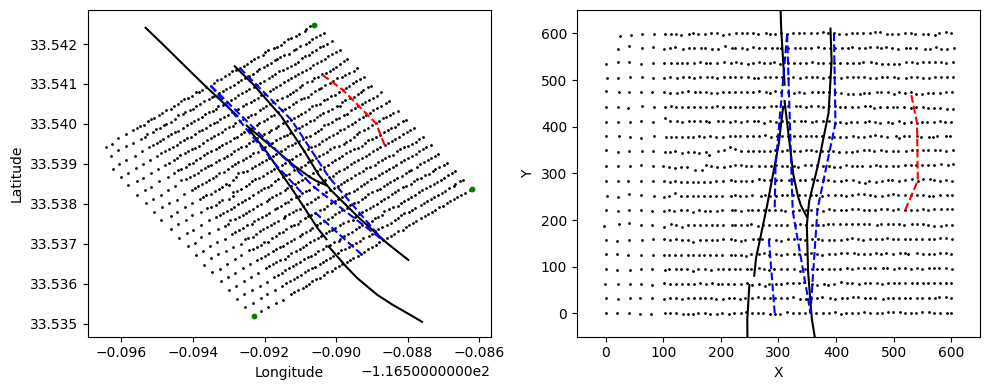

In [17]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all_new, lat_stations_all_new, c='k', label='Original',s = 1)
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax.plot(lon_fault_infer, lat_fault_infer, 'r--')
for j in range(1,5):
    ax.plot(lon_fault_wade[j], lat_fault_wade[j], 'b--')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new, c='k', label='Original',s = 1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'r--')
for j in range(1,5):
    ax.plot(x_faults_wade[j], y_faults_wade[j], 'b--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
plt.tight_layout()

### Interpolate

In [18]:
# generate grid
xx = np.linspace(np.min(x_centroid_partition), np.max(y_centroid_partition), num_x)
yy = np.linspace(np.min(y_centroid_partition), np.max(y_centroid_partition), num_y)
A,B = np.meshgrid(xx, yy)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
x_grid = X_star[:,0]
y_grid = X_star[:,1]

points = np.column_stack((x_centroid_partition, y_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index = []
x_inter_in = []
y_inter_in = []
for i in range(len(x_grid)):
    if polygon.contains(Point(x_grid[i], y_grid[i])):
        index.append(i)
        x_inter_in.append(x_grid[i])
        y_inter_in.append(y_grid[i])

In [19]:
# 坐标逆变换
affine_matrix_inv = np.linalg.inv(affine_matrix)
# stations in
lon_inter_in = np.zeros(len(x_inter_in))
lat_inter_in = np.zeros(len(y_inter_in))
for i in range(len(x_inter_in)):
    loc_sta_new = np.array([x_inter_in[i],y_inter_in[i],1])
    loc_sta = np.dot(affine_matrix_inv,loc_sta_new)
    lon_inter_in[i] = loc_sta[0]
    lat_inter_in[i] = loc_sta[1]

In [20]:
vs_inter_fund_horizon_in = np.zeros((N,len(index)))
vs_inter_fund_horizon_in_pert = np.zeros((N,len(index)))
vs_inter_horizon_in = np.zeros((N,len(index)))
vs_inter_horizon_in_pert = np.zeros((N,len(index)))
ele_inter = np.zeros((N,len(index)))
for i in range(N):
    print('Interpolating horizon %d/%d' % (i+1,N))
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_horizon_in[i,:] = zz.reshape(len(xx)*len(yy))[index]
    vs_inter_horizon_in_pert[i,:] = vs_inter_horizon_in[i,:] - np.mean(vs_inter_horizon_in[i,:])
    vs_inter_horizon_in_pert[i,:] = vs_inter_horizon_in_pert[i,:]/np.mean(vs_inter_horizon_in[i,:])
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon_fund[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_fund_horizon_in[i,:] = zz.reshape(len(xx)*len(yy))[index]
    vs_inter_fund_horizon_in_pert[i,:] = vs_inter_fund_horizon_in[i,:] - np.mean(vs_inter_fund_horizon_in[i,:])
    vs_inter_fund_horizon_in_pert[i,:] = vs_inter_fund_horizon_in_pert[i,:]/np.mean(vs_inter_fund_horizon_in[i,:])
OK = OrdinaryKriging(x_stations_in, y_stations_in, elevation_stations_in, variogram_model=type_interp,nlags=3)
zz,ss = OK.execute('grid', xx, yy)
ele_inter = zz.reshape(len(xx)*len(yy))[index]

Interpolating horizon 1/45
Interpolating horizon 2/45
Interpolating horizon 3/45
Interpolating horizon 4/45
Interpolating horizon 5/45
Interpolating horizon 6/45
Interpolating horizon 7/45
Interpolating horizon 8/45
Interpolating horizon 9/45
Interpolating horizon 10/45
Interpolating horizon 11/45
Interpolating horizon 12/45
Interpolating horizon 13/45
Interpolating horizon 14/45
Interpolating horizon 15/45
Interpolating horizon 16/45
Interpolating horizon 17/45
Interpolating horizon 18/45
Interpolating horizon 19/45
Interpolating horizon 20/45
Interpolating horizon 21/45
Interpolating horizon 22/45
Interpolating horizon 23/45
Interpolating horizon 24/45
Interpolating horizon 25/45
Interpolating horizon 26/45
Interpolating horizon 27/45
Interpolating horizon 28/45
Interpolating horizon 29/45
Interpolating horizon 30/45
Interpolating horizon 31/45
Interpolating horizon 32/45
Interpolating horizon 33/45
Interpolating horizon 34/45
Interpolating horizon 35/45
Interpolating horizon 36/45
I

In [21]:
# 对vs_inter进行平滑处理,用gaussain filter
if flag_smooth == 1:
    vs_inter_smooth = np.zeros((N,len(index)))
    vs_inter_fund_smooth = np.zeros((N,len(index)))
    for i in range(len(index)):
        vs_inter_smooth[:,i] = gaussian_filter(vs_inter_horizon_in[:,i], sigma=2)
        vs_inter_fund_smooth[:,i] = gaussian_filter(vs_inter_fund_horizon_in[:,i], sigma=2)

### Verticle traces

In [22]:
# define traces
traces = {}
for i in range(4,18):
    y = 30*(i-1)
    traces[i] = np.zeros([2,2])
    traces[i][0,0] = np.min(x_inter_in)
    traces[i][0,1] = y
    traces[i][1,0] = np.max(x_inter_in)
    traces[i][1,1] = y

In [23]:
def extract_points(tag_trace,x_inter_in,y_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (y_inter_in[1]-y_inter_in[0])**2 + (x_inter_in[1]-x_inter_in[0])**2 ))/2
    index = []
    
    for i in range(len(x_inter_in)):
        x0 = x_inter_in[i]
        y0 = y_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [24]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])

    if line_slope == 0:
        #print('slope == 0')
        #print(external_point[1],point1_line[0])
        return  point1_line[0],external_point[1]
    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [25]:
x_inter_verti = {}
y_inter_verti = {}
vs_inter_verti = {}
vs_inter_verti_pert = {}
vs_inter_fund_verti = {}   
vs_inter_fund_verti_pert = {}
ele_verti = {}
indexes = {}
loc_starts = {}
for tag in traces.keys():
    print(tag)
    #index = extract_points(tag,x_inter_in,y_inter_in)
    yy = list(set(y_inter_in))
    index_this = np.argmin(np.abs(yy-traces[tag][0][1]))
    index = np.where(y_inter_in == yy[index_this])[0]
    
    indexes[tag] = index
    x_inter_verti[tag] = np.array(x_inter_in)[index]
    y_inter_verti[tag] = np.array(y_inter_in)[index]
    
    vs_inter_verti[tag] = []
    vs_inter_fund_verti[tag] = []
    vs_inter_verti_pert[tag] = []
    vs_inter_fund_verti_pert[tag] = []
    ele_verti[tag] = []
    loc_start = find_intersection_point(traces[tag][0], traces[tag][1], [x_inter_verti[tag][0], y_inter_verti[tag][0]])
    loc_starts[tag] = loc_start
    for i in range(N):
        vs_inter_verti[tag].append(vs_inter_horizon_in[i,index])
        vs_inter_fund_verti[tag].append(vs_inter_fund_horizon_in[i,index])
        vs_inter_verti_pert[tag].append(vs_inter_verti[tag][i] - np.mean(vs_inter_verti[tag][i]))
        vs_inter_verti_pert[tag][i] = vs_inter_verti_pert[tag][i]/np.mean(vs_inter_verti[tag][i])
        vs_inter_fund_verti_pert[tag].append(vs_inter_fund_verti[tag][i] - np.mean(vs_inter_fund_verti[tag][i]))
        vs_inter_fund_verti_pert[tag][i] = vs_inter_fund_verti_pert[tag][i]/np.mean(vs_inter_fund_verti[tag][i])
    ele_verti[tag].append(np.array(ele_inter)[index])

4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [26]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [27]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global x_faults
    global y_faults
    global x_inter_verti
    global y_inter_verti

    x_fault_inter = []
    y_fault_inter = []

    for key in faults.keys():
        x_fault = x_faults[key]
        y_fault = y_faults[key]
        index_fault_start = np.argmin(y_fault)
        index_fault_end = np.argmax(y_fault)
        p1 = [x_fault[index_fault_start], y_fault[index_fault_start]]
        q1 = [x_fault[index_fault_end], y_fault[index_fault_end]]
        index_trace_start = np.argmin(x_inter_verti[tag_trace])
        index_trace_end = np.argmax(x_inter_verti[tag_trace])
        p2 = [x_inter_verti[tag_trace][index_trace_start], y_inter_verti[tag_trace][index_trace_start]]
        q2 = [x_inter_verti[tag_trace][index_trace_end], y_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            x_trace = x_inter_verti[tag_trace]
            y_trace = y_inter_verti[tag_trace]

            min_distance = float('inf')

            for lon1, lat1 in zip(x_fault, y_fault):
                for lon2, lat2 in zip(x_trace, y_trace):
                    distance = math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
                    if distance < min_distance:
                        min_distance = distance
                        x_fault_near = lon1
                        y_fault_near = lat1
                        x_trace_near = lon2
                        y_trace_near = lat2
                    
            x_fault_inter.append( x_trace_near )
            y_fault_inter.append( y_trace_near )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return x_fault_inter, y_fault_inter

### Save

In [28]:
# save as npz
z = np.arange(0,N*dz,dz)
if flag_save == 1:
    print('Save as npz')
    filename = dir_inv + 'vs_inter.npz'
    if os.path.exists(filename):
        os.remove(filename)
    # save as npz
    np.savez(filename,ele = ele_inter,vs_fund = vs_inter_fund_horizon_in,vs = vs_inter_horizon_in, vs_fund_pert = vs_inter_fund_horizon_in_pert, vs_pert = vs_inter_horizon_in_pert, x = x_inter_in,y = y_inter_in, depth = z,dz=dz,N=N,lon=lon_inter_in,lat=lat_inter_in)
    filename = dir_inv + 'vs_inter_verti.npz'
    if os.path.exists(filename):
        os.remove(filename)
    np.savez(filename,x = x_inter_verti, y = y_inter_verti, vs = vs_inter_verti,vs_fund = vs_inter_fund_verti, vs_pert = vs_inter_verti_pert, vs_fund_pert = vs_inter_fund_verti_pert, ele = ele_verti, loc_start = loc_starts, indexes = indexes)


    if flag_smooth == 1:
        filename = dir_inv + 'vs_inter_smooth.npz'
        if os.path.exists(filename):
            os.remove(filename)
        np.savez(filename,ele = ele_inter,vs_fund = vs_inter_fund_smooth,vs = vs_inter_smooth, x = x_inter_in,y = y_inter_in, depth = z,dz=dz,N=N,lon=lon_inter_in,lat=lat_inter_in)

Save as npz
